In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import torch

%matplotlib inline
np.random.seed(1)

# 1. Dataset

In [3]:
train_dataset = h5py.File('/content/drive/MyDrive/Colab Notebooks/datasets/train_signs.h5', "r")
train_set_x_orig = torch.tensor(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = torch.tensor(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('/content/drive/MyDrive/Colab Notebooks/datasets/test_signs.h5', "r")
test_set_x_orig = torch.tensor(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = torch.tensor(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

In [4]:
train_set_x_orig.shape

torch.Size([1080, 64, 64, 3])

In [5]:
X_train = train_set_x_orig/255

In [6]:
X_test = test_set_x_orig/255

In [7]:
X_train.shape

torch.Size([1080, 64, 64, 3])

In [8]:
X_test.shape

torch.Size([120, 64, 64, 3])

In [9]:
train_set_y_orig.shape

torch.Size([1080])

IndexError: ignored

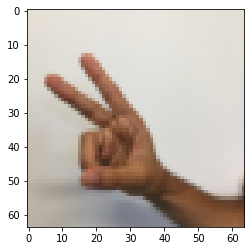

In [ ]:
# Example of a picture
index = 6
plt.imshow(train_set_x_orig[index])
print ("y = " + str(np.squeeze(train_set_y_orig[:, index])))

### 1.1 DataLoaders

In [10]:
from torch.utils.data import DataLoader, TensorDataset, random_split

In [11]:
train_dataset = TensorDataset(X_train, train_set_y_orig)
val_dataset = TensorDataset(X_test, test_set_y_orig)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 2. Model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### 2.1 Base Model

In [26]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    images = images.permute(0, 3, 1, 2)
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  
  def validation_step(self, batch):
    images, labels = batch
    images = images.permute(0, 3, 1, 2)
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss":loss.detach(), "val_acc":acc}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [r['val_loss'] for r in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [r['val_acc'] for r in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], train loss: {result['train_loss']:.4f}, validation loss: {result['val_loss']:.4f}, validation accuracy: {result['val_acc']:.4f}")

In [15]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

* Conv2d: stride 1, padding "same"
* ReLU
* MaxPool: 8x8 filter size, 8x8 stride, padding "same"
* Conv2d: stride 1, padding "same"
* ReLU
* MaxPool: 4x4 filter size, 4x4 stride, padding "same"
* Flatten
* FullyConnected: no non-linear activation function 

### 2.2 CNN Model

In [27]:
class CNNModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=4, stride=1, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(8, 8),
        nn.Conv2d(8, 16, kernel_size=2, stride=1, padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(4, 4),
        nn.Flatten(),
        nn.Linear(64, 6))
  def forward(self, xb):
    return self.network(xb)

In [28]:
model = CNNModel()
model

CNNModel(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [25]:
for images, labels in train_loader:
  images = images.permute(0, 3, 1, 2)
  print("images shape:", images.shape)
  out = model(images)
  print("out shape", out.shape)
  print("out[0]:", out[0])

images shape: torch.Size([64, 3, 64, 64])
out shape torch.Size([64, 6])
out[0]: tensor([ 0.2451,  0.1258, -0.0261,  0.1530, -0.0693,  0.1507],
       grad_fn=<SelectBackward>)
images shape: torch.Size([64, 3, 64, 64])
out shape torch.Size([64, 6])
out[0]: tensor([ 0.2618,  0.1435, -0.0266,  0.1689, -0.0806,  0.1430],
       grad_fn=<SelectBackward>)
images shape: torch.Size([64, 3, 64, 64])
out shape torch.Size([64, 6])
out[0]: tensor([ 0.2571,  0.1498, -0.0103,  0.1646, -0.0834,  0.1413],
       grad_fn=<SelectBackward>)
images shape: torch.Size([64, 3, 64, 64])
out shape torch.Size([64, 6])
out[0]: tensor([ 0.2600,  0.1409, -0.0249,  0.1624, -0.0870,  0.1644],
       grad_fn=<SelectBackward>)
images shape: torch.Size([64, 3, 64, 64])
out shape torch.Size([64, 6])
out[0]: tensor([ 0.2489,  0.1332, -0.0167,  0.1500, -0.0624,  0.1416],
       grad_fn=<SelectBackward>)
images shape: torch.Size([64, 3, 64, 64])
out shape torch.Size([64, 6])
out[0]: tensor([ 0.2517,  0.1141, -0.0442,  0.13

# 3. Train the Model

In [29]:
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [30]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    result = evaluate(model, val_loader)
    result["train_loss"] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [31]:
evaluate(model, val_loader)

{'val_acc': 0.1685267835855484, 'val_loss': 1.8005592823028564}

In [38]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.009

In [39]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train loss: 1.7257, validation loss: 1.6360, validation accuracy: 0.3460
Epoch [1], train loss: 1.5793, validation loss: 1.4416, validation accuracy: 0.4040
Epoch [2], train loss: 1.3438, validation loss: 1.3115, validation accuracy: 0.4554
Epoch [3], train loss: 1.1997, validation loss: 1.2056, validation accuracy: 0.5000
Epoch [4], train loss: 1.0497, validation loss: 1.0032, validation accuracy: 0.5871
Epoch [5], train loss: 0.9616, validation loss: 0.9661, validation accuracy: 0.6071
Epoch [6], train loss: 0.8871, validation loss: 0.8112, validation accuracy: 0.6964
Epoch [7], train loss: 0.7842, validation loss: 0.7516, validation accuracy: 0.7344
Epoch [8], train loss: 0.7437, validation loss: 0.8102, validation accuracy: 0.6886
Epoch [9], train loss: 0.7126, validation loss: 0.8345, validation accuracy: 0.6328
Epoch [10], train loss: 0.6796, validation loss: 0.6804, validation accuracy: 0.7467
Epoch [11], train loss: 0.5927, validation loss: 0.6245, validation accurac

In [44]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-')
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.title("Accuracy vs. No. of epochs")

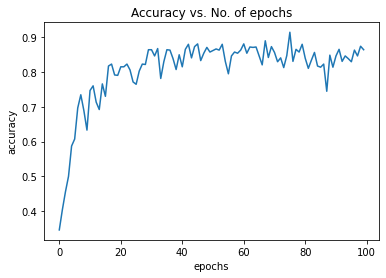

In [45]:
plot_accuracies(history)

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

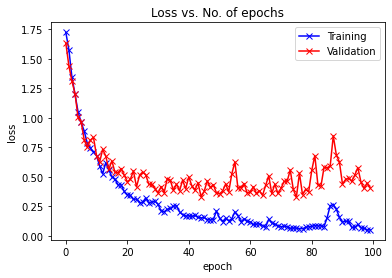

In [43]:
plot_losses(history)